In [2]:
import warnings
warnings.filterwarnings('ignore')
    
import arviz as az
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
from gala.units import UnitSystem
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
from tqdm.notebook import tqdm
import astropy.table as at
from aesara_theano_fallback import tensor as tt
import exoplanet.units as xu
import json
import corner
import pandas as pd

from yellowcard.model_pymc3 import TimingArgumentModelPymc3

In [5]:
plt.rcParams.update({"text.usetex":False,"font.size":16})

palette = {"fid": "#7B55F3",
           "vdmmod":'#FFB201',
           "vdm":"#DE2280"}

labels = {"vdm":r"vdMG08 Dist. + HST PM",
          "vdmmod":r"Cepheid Dist. + HST PM",
          "fid":r"Cepheid Dist. + Gaia PM"}

modelChoices = ["vdm2012","fiducial2021","Dataset3"]


In [4]:
usys = UnitSystem(1e12*u.Msun, u.kpc, u.Gyr, u.radian)

____
# Calculate means - run this first

## Mass vs. vtravel

In [87]:
# --------------------- #
# get those means bby!! #
# --------------------- #
vtravels = np.arange(0,105,5)
vtravels = np.concatenate( (np.arange(0,105,5), np.array([32])) )

means_vtravel = {}
stds_vtravel = {}

for mod in modelChoices:
    means_vtravel[mod]={}
    stds_vtravel[mod]={}
    Ms, rs, es, etas, alphas = [],[],[],[],[]
    Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds = [],[],[],[],[]
    means_vtravel[mod]['vtravel'] = vtravels
    stds_vtravel[mod]['vtravel'] = vtravels
    
    for vs in vtravels:
        data = az.from_json(f"../pymc3-data/{mod}_vtravel_{vs}.json")
        
        for param,arr,arr_stds in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
            arr.append(np.asarray((data.posterior[param]).mean()))
            arr_stds.append(np.asarray((data.posterior[param]).std()))
            
    for param,arr,arr_stds  in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
        means_vtravel[mod][param] = np.array(arr)
        stds_vtravel[mod][param] = np.array(arr_stds)


## Mass error vs. pm error

In [88]:
# mass error as function of proper motion improvement
pm_errs = np.array([1,2,4,8,16])

means_pmimprov = {}
stds_pmimprov = {}

for mod in modelChoices:
    means_pmimprov[mod]={}
    stds_pmimprov[mod]={}
    Ms, rs, es, etas, alphas = [],[],[],[],[]
    Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds = [],[],[],[],[]
    means_pmimprov[mod]['pm_errs'] = pm_errs
    stds_pmimprov[mod]['pm_errs'] = pm_errs
    
    for improv in pm_errs:
        data = az.from_json(f"../pymc3-data/{mod}_pmimprov_{improv}.json")
        
        for param,arr,arr_stds in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
            arr.append(np.asarray((data.posterior[param]).mean()))
            arr_stds.append(np.asarray((data.posterior[param]).std()))
            
    for param,arr,arr_stds  in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
        means_pmimprov[mod][param] = np.array(arr)
        stds_pmimprov[mod][param] = np.array(arr_stds)
                

___

# Calculate errorbars

In [18]:
model = ["vdm2012","fiducial2021","Dataset3"]
label = ["vdMG08 Dist. + HST PM","Cepheid Dist. + Gaia PM","Cepheid Dist. + HST PM"]
for i in range(3):
    data = az.from_json(f"../pymc3-data/{model[i]}_vtravel_32.json")
    m_lg_values = np.asarray(data.posterior['M']).ravel()
    print(f"{label[i]}: ",np.percentile(m_lg_values, [16, 50, 84]))

vdMG08 Dist. + HST PM:  [3.51926983 3.99241123 4.62251719]
Cepheid Dist. + Gaia PM:  [3.9953393  4.54185148 5.32181489]
Cepheid Dist. + HST PM:  [3.69767244 4.03178238 4.50035257]


In [89]:
model = ["vdm2012","fiducial2021","Dataset3"]
label = ["vdMG08 Dist. + HST PM","Cepheid Dist. + Gaia PM","Cepheid Dist. + HST PM"]
for i in range(3):
    data = az.from_json(f"../pymc3-data/{model[i]}_vtravel_32.json")
    m_lg_values = np.asarray(data.posterior['M']).ravel()
    print(f"{label[i]}: ",np.percentile(m_lg_values, [16, 50, 84]))

vdMG08 Dist. + HST PM:  [3.61635946 4.32188885 5.74765394]
Cepheid Dist. + Gaia PM:  [3.9953393  4.54185148 5.32181489]
Cepheid Dist. + HST PM:  [3.80645916 4.31459143 5.23495222]


___
# Plots

## corner plots for all variables

In [90]:
# universal color and style choices
colors = {"vdm2012":"#DE2280",
          "fiducial2021":'#FFB201',
          "Dataset3": "#7B55F3"}

In [91]:
incl = 32
dat = 'vdm2012'
data = az.from_json(f"../pymc3-data/{dat}_vtravel_{incl}.json")


In [92]:
data.posterior

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 8000, m31_icrs_xyz_dim_0: 3)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 ... 7995 7996 7997 7998 7999
  * m31_icrs_xyz_dim_0  (m31_icrs_xyz_dim_0) int64 0 1 2
Data variables: (12/21)
    vtravel_mag         (chain, draw) float64 37.55 26.12 34.5 ... 24.72 25.41
    vtravel_lon         (chain, draw) float64 1.09 0.8376 1.153 ... 1.204 1.096
    vtravel_lat         (chain, draw) float64 -0.4479 -0.6682 ... -0.7244
    r                   (chain, draw) float64 750.9 758.1 759.7 ... 736.8 726.3
    M                   (chain, draw) float64 3.012 3.552 3.196 ... 3.752 3.83
    eta                 (chain, draw) float64 -2.182 -2.134 ... -2.105 -2.086
    ...                  ...
    sun_m31_dist        (chain, draw) float64 746.9 754.0 755.7 ... 732.8 722.3
    m31_icrs_xyz        (chain, draw, m31_icrs_xyz_dim_0) float64 551.7 ... 4...
    alpha               (chain, draw) float64 -1.269 -2.75 1.893 ... 2.957 2.514
    model_pmra          (chain, draw) float64 0.2338 0.2105 ... 0.1386 0.1517
    model_pmdec         (chain, draw) float64 -0.09035 -0.08628 ... -0.1493
    model_rv            (chain, draw) float64 -306.5 -307.0 ... -308.1 -308.4
Attributes:
    created_at:                 2022-01-12T21:06:50.195832
    arviz_version:              0.11.0
    inference_library:          pymc3
    inference_library_version:  3.9.3
    sampling_time:              197.90565991401672
    tuning_steps:               4000

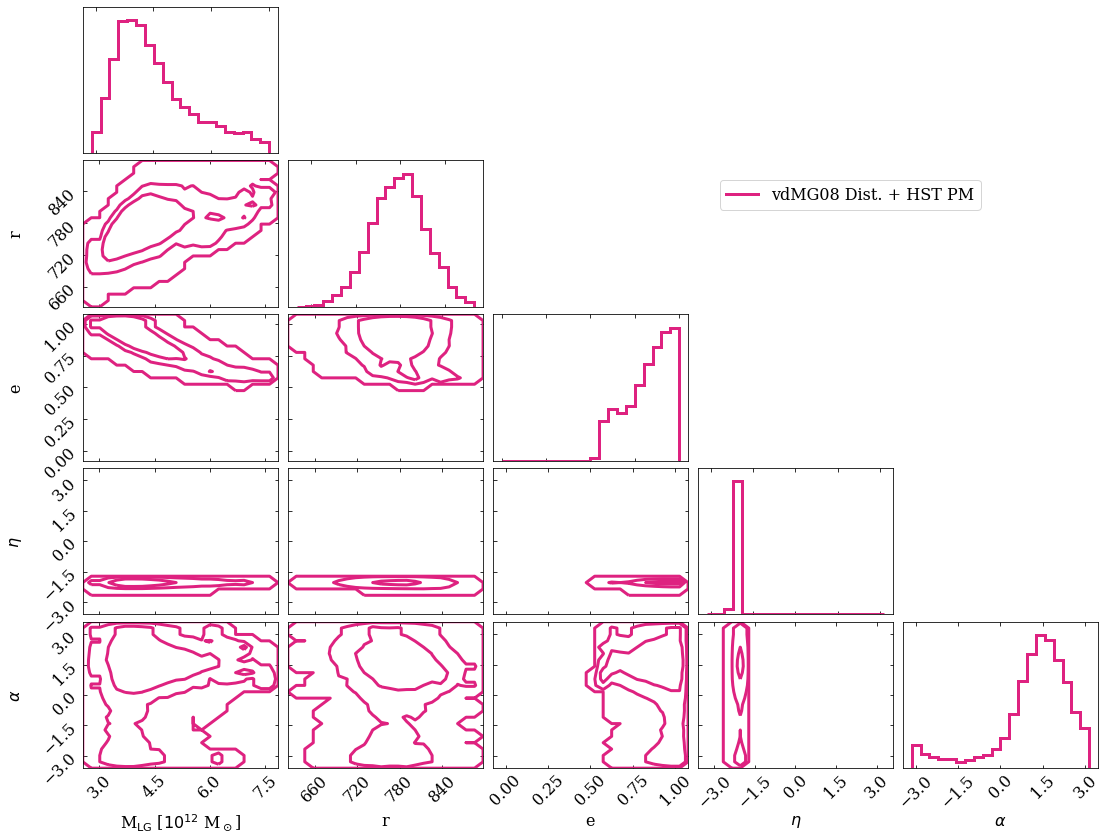

In [123]:
dataset = "vdm2012"
label = labels['vdm']
vt = 32
fig = plt.figure(figsize=(16,12))

data = az.from_json(f"../pymc3-data/{dataset}_vtravel_{incl}.json")
howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e","eta","alpha"]])
corner.corner(howdy.T,
                labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r","e",r"$\eta$",r"$\alpha$"],
                plot_datapoints=False,
                plot_density=False,
                color=palette['vdm'],
#                 linestyles=style[i],
                fig=fig,
                levels=[0.68, 0.95, 99.7],
                contour_kwargs={"linewidths":3},
                hist_kwargs={"linewidth":3},
                contourf_kwargs={"linestyles":3},
                range=[(2.9,7.5), (640,880), (0,1),(-np.pi,np.pi),(-np.pi,np.pi)]
             );
plt.plot(0,0,lw=3,color=palette['vdm'],label=label)
fig.legend(loc=(0.65,0.75))
plt.savefig(f"../plots/analyze-runs-all-{dataset}.pdf")
plt.show()





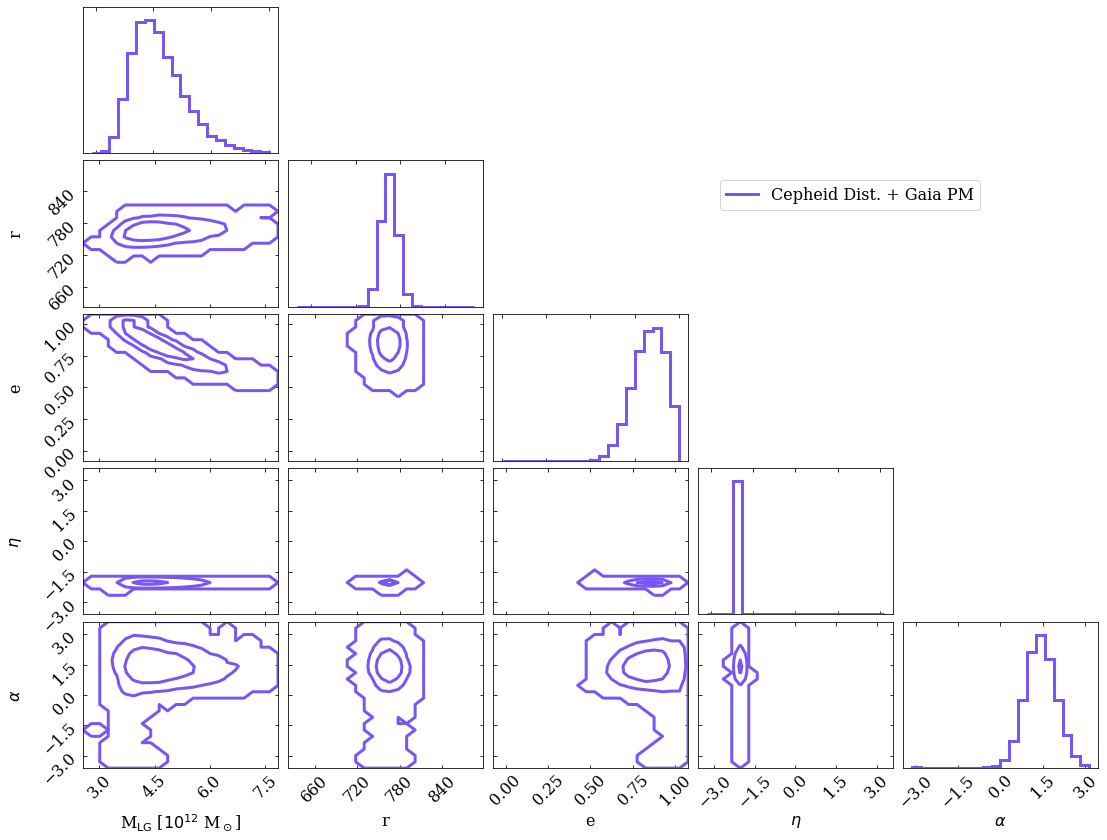

In [124]:
dataset = "fiducial2021"
label = labels['fid']
vt = 32
fig = plt.figure(figsize=(16,12))

data = az.from_json(f"../pymc3-data/{dataset}_vtravel_{incl}.json")
howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e","eta","alpha"]])
corner.corner(howdy.T,
                labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r","e",r"$\eta$",r"$\alpha$"],
                plot_datapoints=False,
                plot_density=False,
                color=palette['fid'],
#                 linestyles=style[i],
                fig=fig,
                levels=[0.68, 0.95, 99.7],
                contour_kwargs={"linewidths":3},
                hist_kwargs={"linewidth":3},
                contourf_kwargs={"linestyles":3},
                range=[(2.9,7.5), (640,880), (0,1),(-np.pi,np.pi),(-np.pi,np.pi)]
             );
plt.plot(0,0,lw=3,color=palette['fid'],label=label)
fig.legend(loc=(0.65,0.75))
plt.savefig(f"../plots/analyze-runs-all-{dataset}.pdf")
plt.show()





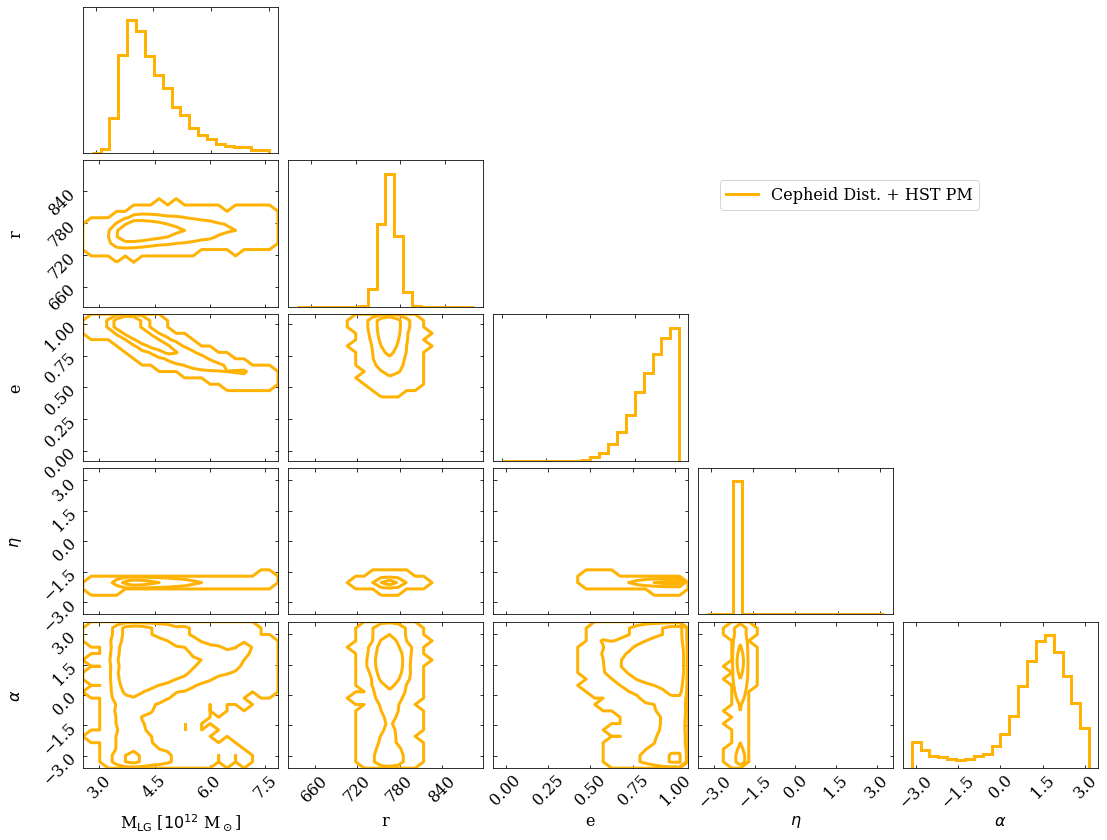

In [125]:
dataset = "Dataset3"
label = labels['vdmmod']
vt = 32
fig = plt.figure(figsize=(16,12))

data = az.from_json(f"../pymc3-data/{dataset}_vtravel_{incl}.json")
howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e","eta","alpha"]])
corner.corner(howdy.T,
                labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r","e",r"$\eta$",r"$\alpha$"],
                plot_datapoints=False,
                plot_density=False,
                color=palette['vdmmod'],
#                 linestyles=style[i],
                fig=fig,
                levels=[0.68, 0.95, 99.7],
                contour_kwargs={"linewidths":3},
                hist_kwargs={"linewidth":3},
                contourf_kwargs={"linestyles":3},
                range=[(2.9,7.5), (640,880), (0,1),(-np.pi,np.pi),(-np.pi,np.pi)]
             );
plt.plot(0,0,lw=3,color=palette['vdmmod'],label=label)
fig.legend(loc=(0.65,0.75))
plt.savefig(f"../plots/analyze-runs-all-{dataset}.pdf")
plt.show()





## Model Comparison

vdm2012 vdMG08 Dist. + HST PM solid is color #DE2280
Dataset3 Cepheid Dist. + HST PM solid is color #FFB201
fiducial2021 Cepheid Dist. + Gaia PM solid is color #7B55F3


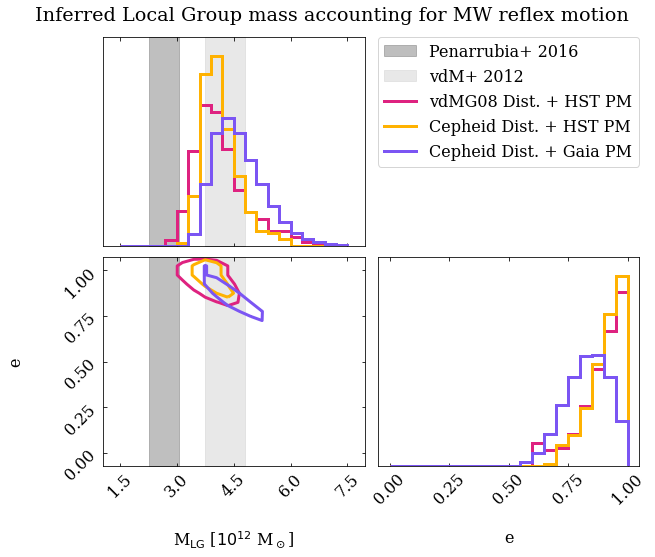

In [8]:
dataChoices = ["vdm2012",'Dataset3',"fiducial2021"]
label = [r"vdMG08 Dist. + HST PM",r"Cepheid Dist. + HST PM",r"Cepheid Dist. + Gaia PM"]
color = [palette['vdm'],palette['vdmmod'],palette['fid']]

incl = "32"

style = ['solid','solid','solid']
widths = [3,3,3]


i=0
fig,ax = plt.subplots(2,2,figsize=(10,8))
for dat,name in zip(dataChoices,label):
    print(dat, name,style[i], "is color", color[i])
    data = az.from_json(f"../pymc3-data/{dat}_vtravel_{incl}.json")
    howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","e"]])
    corner.corner(howdy.T,
                        labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","e"],
                        plot_datapoints=False,
                        plot_density=False,
                        color=color[i],
                        linestyles=style[i],
                        fig=fig,
                        levels=[0.68],
                        contour_kwargs={"linestyles":style[i],"linewidths":widths[i]},
                        hist_kwargs={"linestyle":style[i],"linewidth":widths[i]},
                        contourf_kwargs={"linestyles":style[i]},
                        range=[(1.5,7.5), (0,1)],
                 );
    i+=1
    
  

for gojo in range(3):
    plt.plot(0,0,
             lw=3,
             color=color[gojo],
             label=fr"{label[gojo]}")
penarrubia16low, penarrubia16high = [2.26, 3.06]
vdm12low, vdm12high = [3.74,4.8]

# to fix the VERY SLIGHT MISALIGNED xlim on the mass :| 
xlims = ax[1][0].get_xlim()
ax[0][0].set_xlim(xlims)


for row in range(2):
    ylims = ax[row][0].get_ylim()
    ax[row][0].fill_betweenx(np.linspace(ylims[0],ylims[1]),
                             penarrubia16low, penarrubia16high,
                             color='grey',
                             alpha=0.5)
    ax[row][0].fill_betweenx(np.linspace(ylims[0],ylims[1]),
                             vdm12low, vdm12high,
                             color='lightgrey',
                             alpha=0.5)
    
ax[0][0].fill_betweenx(np.linspace(ylims[0],ylims[0]),
                             vdm12low, vdm12high,
                             color='grey',
                             alpha=0.5,
                             label="Penarrubia+ 2016")
ax[0][0].fill_betweenx(np.linspace(ylims[0],ylims[0]),
                             vdm12low, vdm12high,
                             color='lightgrey',
                             alpha=0.5,
                             label="vdM+ 2012")  
    



    
fig.legend(loc=(0.577,0.7))
# fig.suptitle("Chamberlain et al. 2022 inferred local group mass\n accounting for LMC-induced reflex motion of MW disk")
fig.suptitle("Inferred Local Group mass accounting for MW reflex motion")
plt.savefig("../plots/analyze-runs-contour.pdf")
plt.show()





In [65]:
dir(ax[0][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_clipon',
 '_clippath',
 '_colorbars',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_axis_map',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',

In [67]:
ax[0][0].get_ylim()

(0.0, 10203.6)

0 vdm2012 Chamberlain+ 2021 dotted is color Grey
0 Dataset3 van der Marel+ 2012 dotted is color Grey
0 fiducial2021 3 dotted is color Grey
32 vdm2012 Chamberlain+ 2021 solid is color #DE2280
32 Dataset3 van der Marel+ 2012 solid is color #FFB201
32 fiducial2021 3 solid is color #7B55F3


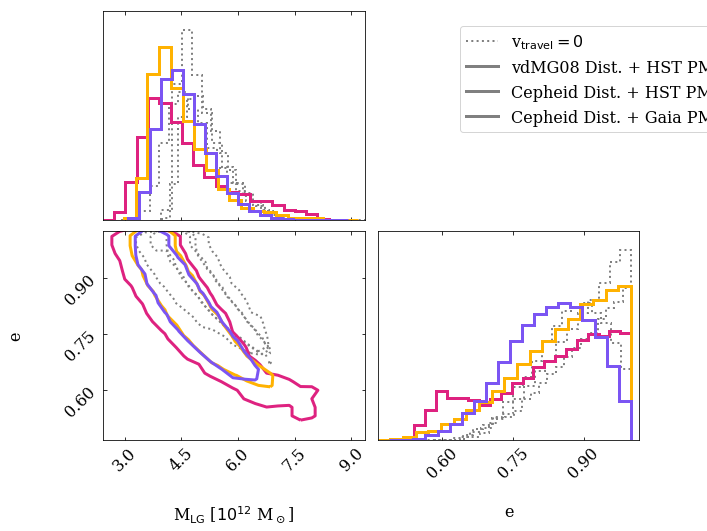

In [102]:
# model comparison where v_t = 0 is in grey

dataChoices = ["vdm2012",'Dataset3',"fiducial2021"]
label = [r"vdMG08 Dist. + HST PM",r"Cepheid Dist. + HST PM",r"Cepheid Dist. + Gaia PM"]

include_vTravel = ["0","32"]
color = ["Grey","Grey","Grey",palette['Extra'],palette['Minor Pairs'],palette['Major Pairs']]
# color = ["white","white","white","white"]
# color = ["white","white",palette['Minor Pairs'],palette["Extra"]]
style = ['dotted','dotted','dotted','solid','solid','solid']
widths = [2,2,2,3,3,3]
model=[ "Old model","Old model","Our model", "Our model","hey","sup"]


i=0
fig = plt.figure(figsize=(10,8))
for incl in include_vTravel:
    for dat,name in zip(dataChoices,label_model):

        # uncomment if running for just dotted contours:
#         if incl != "0":
#             i+=1
#             continue
        print(incl, dat, name,style[i], "is color", color[i])
        data = az.from_json(f"../pymc3-data/{dat}_vtravel_{incl}.json")
        howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e"]])
        howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","e"]])
        corner.corner(howdy.T,
                            labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","e"],
                            plot_datapoints=False,
                            plot_density=False,
                            color=color[i],
                            linestyles=style[i],
                            fig=fig,
                            levels=[ 0.95],
                            contour_kwargs={"linestyles":style[i],"linewidths":widths[i]},
                            hist_kwargs={"linestyle":style[i],"linewidth":widths[i]},
                            contourf_kwargs={"linestyles":style[i]},
#                             range=[(2.9,7.5), (640,880), (0.56,1)]
                     );
        i+=1
        
# fig.savefig(f'../plots/analyze-runs-contour.png',dpi=300)

# plt.plot(0,0,lw=3,color=palette["Major Pairs"],label=r"Cepheids+HST")
# plt.plot(0,0,lw=3,color=palette["Minor Pairs"],label="Gaia+Cepheids")
# plt.plot(0,0,lw=3,color=palette["Extra"],label="HST")
plt.plot(0,0,lw=2,color="gray",linestyle="dotted",label=r"v$_{\rm travel} = 0$")
for gojo in range(3):
    plt.plot(0,0,
             lw=3,
             color=color[gojo],
             label=fr"{label[gojo]}")

for row in range(2):
    ylims = ax[row][0].get_ylim()
    ax[row][0].fill_betweenx(np.linspace(ylims[0],ylims[1]),
                             penarrubia16low, penarrubia16high,
                             color='grey',
                             alpha=0.5)
    ax[row][0].fill_betweenx(np.linspace(ylims[0],ylims[1]),
                             vdm12low, vdm12high,
                             color='lightgrey',
                             alpha=0.5)

fig.legend(loc=(0.65,0.75))
# plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# plt.savefig("../plots/analyze-runs-contour_dotted.png",dpi=300)
# plt.savefig("../plots/analyze-runs-contour_white.png",dpi=300)
plt.show()





In [43]:
# modelChoices = ["vdm2012","fiducial2021"]
# label_model = ["Chamberlain+ 2021", "van der Marel+ 2012"]
# include_vTravel = ["0","32"]
# color = ["Grey","Grey",palette['Minor Pairs'],palette['Minor Pairs']]
# # color = ["white","white","white","white"]
# # color = ["white","white",palette['Minor Pairs'],palette["Extra"]]
# style = ['solid','dotted','solid','dotted']
# widths = [2,2,3,3]
# model=[ "Old model","Old model","Our model", "Our model"]


# i=0
# fig = plt.figure(figsize=(10,8))
# for incl in include_vTravel:
#     for mod,name in zip(modelChoices,label_model):

#         # uncomment if running for just dotted contours:
# #         if incl != "0":
# #             i+=1
# #             continue
#         print(incl, mod, name,style[i], "is color", color[i])
#         data = az.from_json(f"../pymc3-data/{mod}_vtravel_{incl}.json")
#         howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e"]])
#         corner.corner(howdy.T,
#                             labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r [kpc]","e"],
#                             plot_datapoints=False,
#                             plot_density=False,
#                             color=color[i],
#                             linestyles=style[i],
#                             fig=fig,
#                             levels=[ 0.95],
#                             contour_kwargs={"linestyles":style[i],"linewidths":widths[i]},
#                             hist_kwargs={"linestyle":style[i],"linewidth":widths[i]},
#                             contourf_kwargs={"linestyles":style[i]},
# #                             range=[(2.9,7.5), (640,880), (0.56,1)]
#                      );
#         i+=1
        
# fig.savefig(f'../plots/analyze-runs-contour.png',dpi=300)

# plt.plot(0,0,lw=3,color=palette["Minor Pairs"],label=r"Chamberlain et. al 2021")
# plt.plot(0,0,lw=2,color="grey",linestyle="solid",label=r"v$_{\rm travel} = 0$")
# plt.plot(0,0,lw=3,color="gray",linestyle="solid",label="Dataset 1")
# plt.plot(0,0,lw=3,color="gray",linestyle="dashed",label="Dataset 2")
# fig.legend(loc=(0.55,0.75))
# # plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_dotted.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_white.png",dpi=300)
# plt.show()





32 vdm2012 van der Marel+ 2012 solid
32 fiducial2021 Chamberlain+ 2021 solid
0 vdm2012 van der Marel+ 2012 dotted
0 fiducial2021 Chamberlain+ 2021 dotted


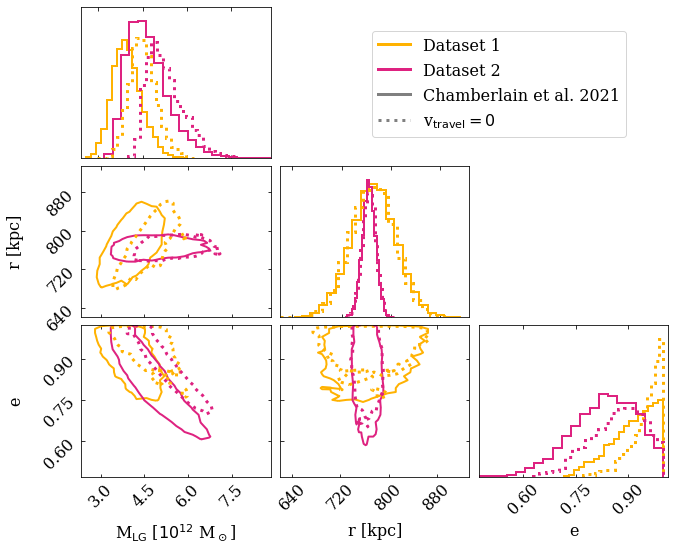

In [10]:
# modelChoices = ["vdm2012","fiducial2021"]
# label_model = ["van der Marel+ 2012","Chamberlain+ 2021"]
# include_vTravel = ["32","0"]
# color = [palette['Minor Pairs'],palette["Extra"],palette['Minor Pairs'],palette["Extra"]]
# # color = ["white","white","white","white"]
# # color = ["white","white",palette['Minor Pairs'],palette["Extra"]]
# style = ['solid','solid','dotted','dotted']
# widths = [2,2,3,3]


# i=0
# fig = plt.figure(figsize=(10,8))
# for incl in include_vTravel:
#     for mod,name in zip(modelChoices,label_model):
    
#         # uncomment if running for just dotted contours:
# #         if incl != "0":
# #             i+=1
# #             continue
#         print(incl, mod, name,style[i])
#         data = az.from_json(f"../pymc3-data/{mod}_vtravel_{incl}.json")
#         howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e"]])
#         corner.corner(howdy.T,
#                         labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r [kpc]","e"],
#                         plot_datapoints=False,
#                         plot_density=False,
#                         color=color[i],
#                         linestyles=style[i],
#                         fig=fig,
#                         levels=[0.95],
#                         contour_kwargs={"linestyles":style[i],"linewidths":widths[i]},
#                         hist_kwargs={"linestyle":style[i],"linewidth":widths[i]},
#                         contourf_kwargs={"linestyles":style[i]},
# #                             range=[(2.9,7.5), (640,880), (0.56,1)]
#                      );
#         i+=1
# fig.savefig(f'../plots/analyze-runs-contour.png',dpi=300)
# plt.plot(0,0,lw=3,color=color[2],label="Dataset 1")
# plt.plot(0,0,lw=3,color=color[3],label="Dataset 2")
# plt.plot(0,0,lw=3,color="grey",label=r"Chamberlain et al. 2021")
# plt.plot(0,0,lw=3,color="grey",linestyle="dotted",label=r"v$_{\rm travel} = 0$")
# plt.arrow(0.5,0.5,-1,-0.5)
# fig.legend(loc=(0.55,0.75))
# plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_dotted.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_white.png",dpi=300)
# plt.show()





___
## Mass vs vtravel

In [103]:
means_vtravel["vdm2012"]["vtravel"][-1]

32

In [104]:
# distance of tracers in the halo vs. "measured" travel velocity from Garavito-Camargo 2021
nico_data = [[60.09584664536741, 45.45454545454547],
 [80.03194888178913, 70.27972027972028],
[100.22364217252397, 83.56643356643357],
[120.1597444089457, 92.65734265734265]] # note this is dist vs. velocity

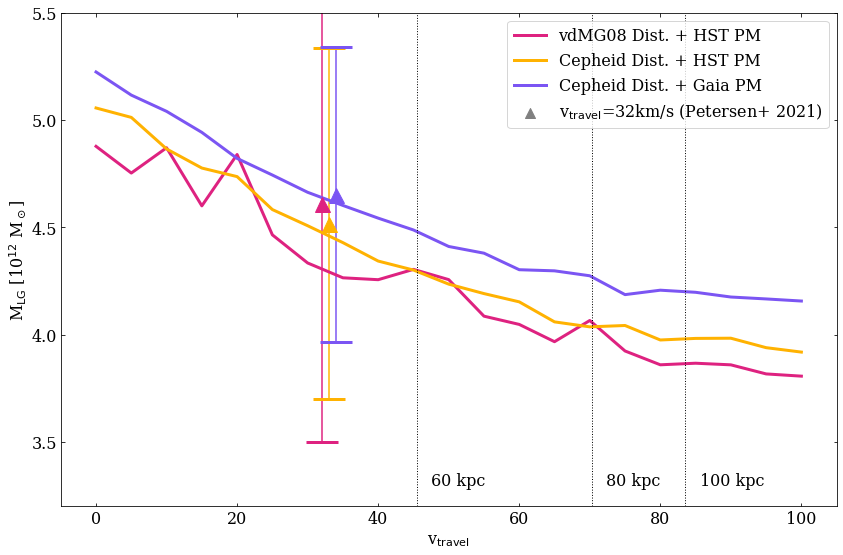

In [109]:
modelChoices = ["vdm2012","Dataset3","fiducial2021"]
label = [r"vdMG08 Dist. + HST PM",r"Cepheid Dist. + HST PM",r"Cepheid Dist. + Gaia PM"]

color = [palette['Extra'],palette['Minor Pairs'],palette['Major Pairs']]

alpha = [0,1,2]

fig,ax=plt.subplots(figsize=(12,8))
for mod,lab,col,al in zip(modelChoices,label,color,alpha):
    plt.plot(means_vtravel[mod]['vtravel'][:-1], means_vtravel[mod]['M'][:-1],
             label=lab, color=col, lw=3)

for mod,lab,col,al in zip(modelChoices,label_model,color,alpha):
    plt.errorbar(x=means_vtravel[mod]['vtravel'][-1]+al, 
                 y=means_vtravel[mod]['M'][-1],
                 yerr=stds_vtravel[mod]['M'][-1],
                 color=col,capsize=16,
                 capthick=3,marker='^',ms=15)

plt.scatter(0,0,label=r'v$_{\rm travel}$=32km/s (Petersen+ 2021)',marker="^",s=100,color='grey')
ax.set_xlabel(r'v$_{\rm travel}$')
ax.set_ylabel(r'M$_{\rm LG}$ [10$^{12}$ M$_\odot$]')
for i in range(len(nico_data))[0:-1]:
    plt.axvline(nico_data[i][1],color="black", linestyle="dotted", lw=1)
    plt.text(nico_data[i][1]+2, 3.3,"%.0f kpc" % nico_data[i][0])
plt.legend(loc="upper right")
plt.ylim(3.2,5.5)
plt.tight_layout()
plt.savefig("../plots/analyze-runs-MvV.pdf")
plt.show()

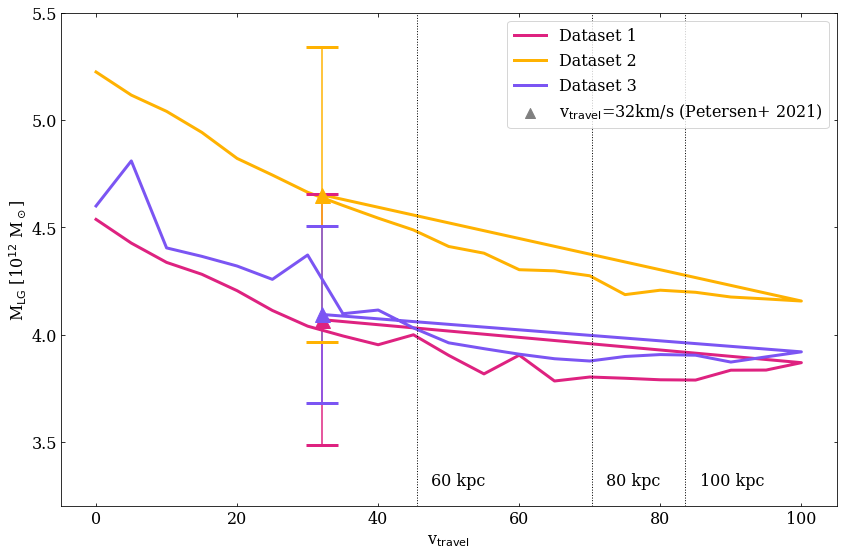

In [58]:
# modelChoices = ["vdm2012","fiducial2021","Dataset3"]
# label_model = ["vdM+ 2012 dataset","Chamberlain+ 2021 dataset","Dataset 3"]
# label_model = ["Dataset 1","Dataset 2","Dataset 3"]
# # label_model = ["Dataset 1","Dataset 2",""]


# color = [palette["Extra"],palette['Minor Pairs'],palette['Major Pairs']]
# alpha = [0,0,0]

# fig,ax=plt.subplots(figsize=(12,8))
# for mod,lab,col,al in zip(modelChoices,label_model,color,alpha):
#     bottoms = means_vtravel[mod]['M']-stds_vtravel[mod]['M']
#     tops = means_vtravel[mod]['M']+stds_vtravel[mod]['M']
    
#     plt.plot(means_vtravel[mod]['vtravel'], means_vtravel[mod]['M'],
#              label=lab, color=col, lw=3)

# for mod,lab,col,al in zip(modelChoices,label_model,color,alpha):
#     plt.errorbar(x=means_vtravel_meas[mod]['vtravel'][1]+al, 
#                  y=means_vtravel_meas[mod]['M'][1],
#                  yerr=stds_vtravel_meas[mod]['M'][1],
#                  color=col,capsize=16,
#                  capthick=3,marker='^',ms=15)

# plt.scatter(0,0,label=r'v$_{\rm travel}$=32km/s (Petersen+ 2021)',marker="^",s=100,color='grey')
# ax.set_xlabel(r'v$_{\rm travel}$')
# ax.set_ylabel(r'M$_{\rm LG}$ [10$^{12}$ M$_\odot$]')
# for i in range(len(nico_data))[0:-1]:
#     plt.axvline(nico_data[i][1],color="black", linestyle="dotted", lw=1)
#     plt.text(nico_data[i][1]+2, 3.3,"%.0f kpc" % nico_data[i][0])
# plt.legend(loc="upper right")
# plt.ylim(3.2,5.5)
# plt.tight_layout()
# plt.savefig("../plots/analyze-runs-MvV.png",dpi=300)
# plt.show()

## All params vs. vtravel

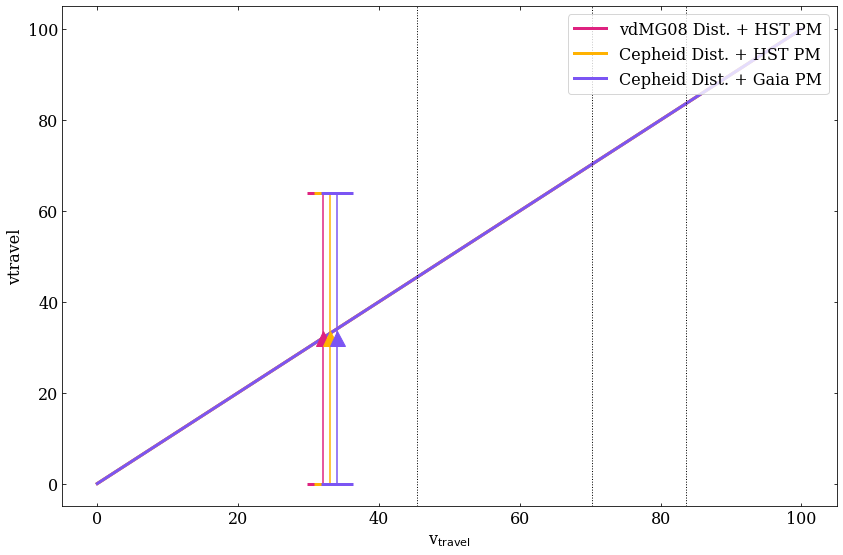

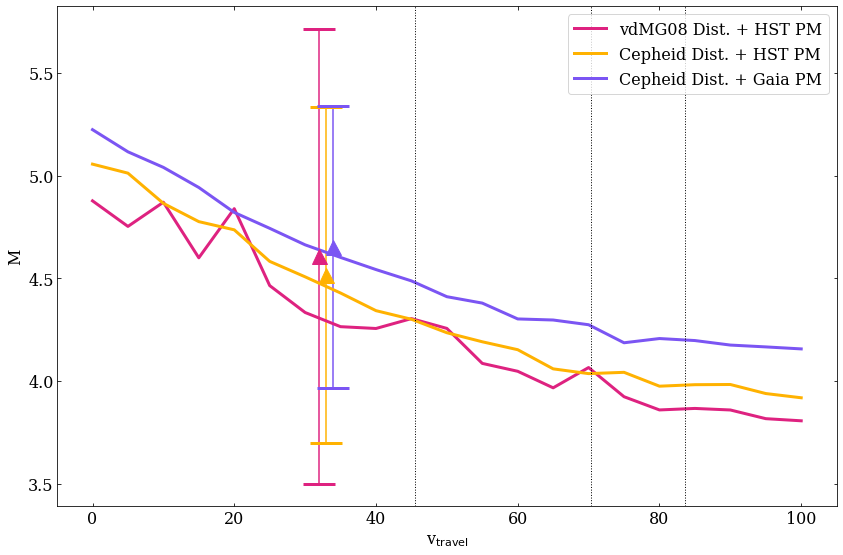

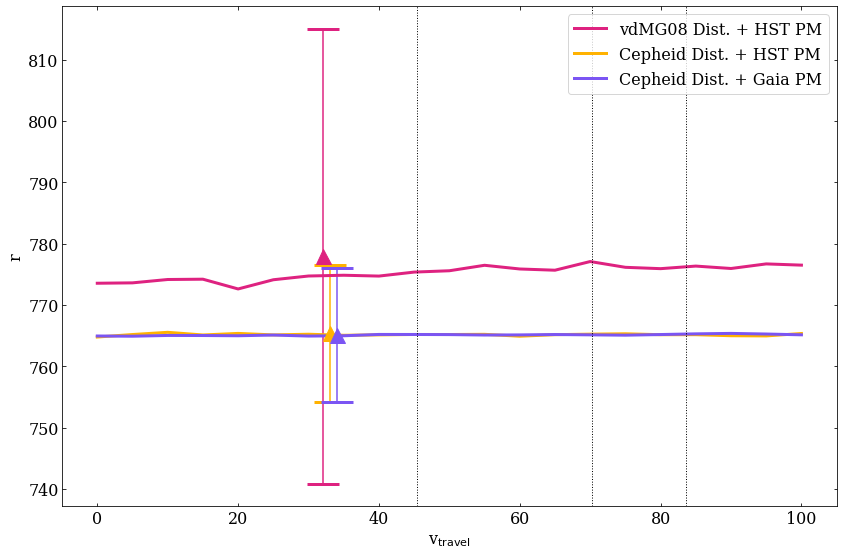

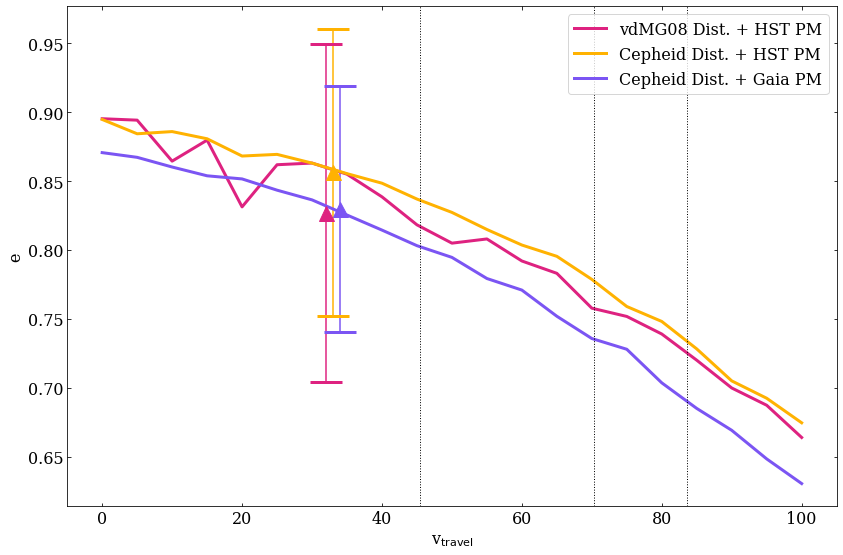

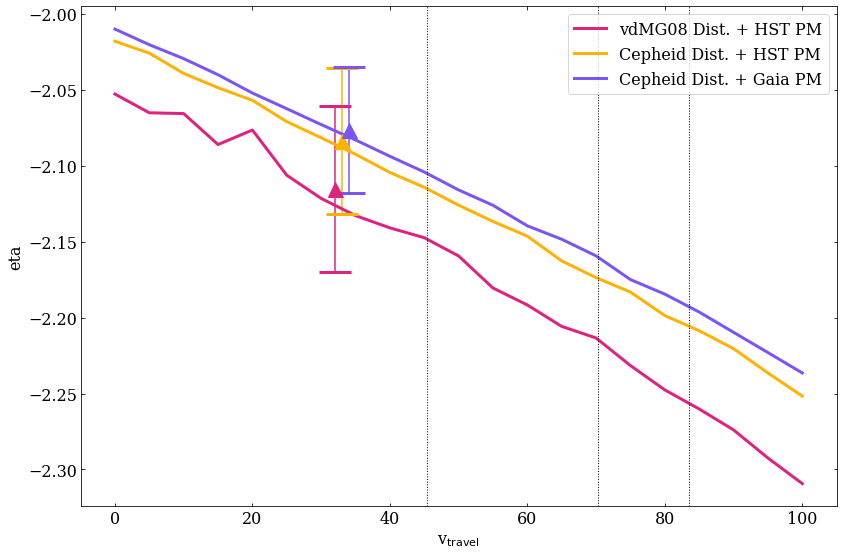

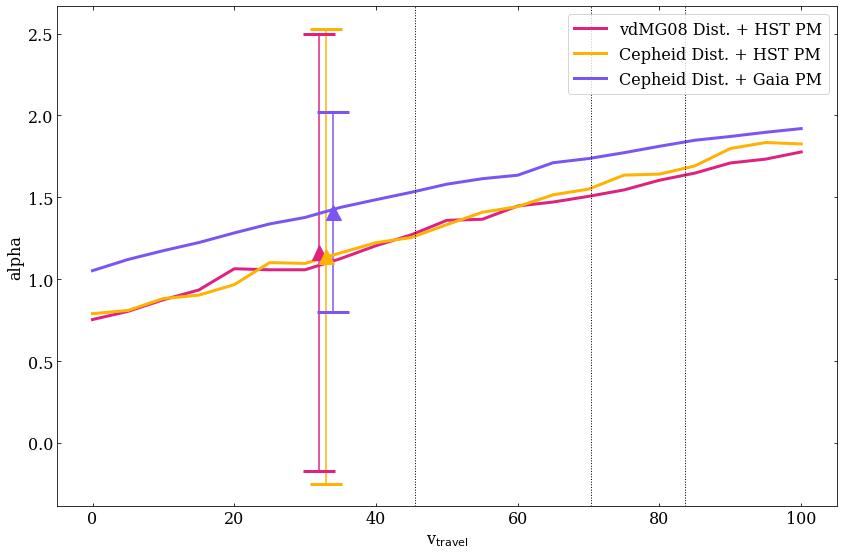

In [112]:
for i in means_vtravel['fiducial2021'].keys():
    
    modelChoices = ["vdm2012","Dataset3","fiducial2021"]
    label = [r"vdMG08 Dist. + HST PM",r"Cepheid Dist. + HST PM",r"Cepheid Dist. + Gaia PM"]
#     label_model = ["Dataset 1","Dataset 2","Dataset 3"]
    # label_model = ["Dataset 1","Dataset 2",""]


    color = [palette["Extra"],palette['Minor Pairs'],palette['Major Pairs']]
    alpha = [0,1,2]

    fig,ax=plt.subplots(figsize=(12,8))
    for mod,lab,col,al in zip(modelChoices,label,color,alpha):
        plt.plot(means_vtravel[mod]['vtravel'][:-1], means_vtravel[mod][i][:-1],
                 label=lab, color=col, lw=3)

    for mod,lab,col,al in zip(modelChoices,label,color,alpha):
        plt.errorbar(x=means_vtravel[mod]['vtravel'][-1]+al, 
                     y=means_vtravel[mod][i][-1],
                     yerr=stds_vtravel[mod][i][-1],
                     color=col,capsize=16,
                     capthick=3,marker='^',ms=15)

#     plt.scatter(0,0,label=r'v$_{\rm travel}$=32km/s (Petersen+ 2021)',marker="^",s=100,color='grey')
    ax.set_xlabel(r'v$_{\rm travel}$')
    ax.set_ylabel(f'{i}')
    for j in range(len(nico_data))[0:-1]:
        plt.axvline(nico_data[j][1],color="black", linestyle="dotted", lw=1)
#         plt.text(nico_data[j][1]+2, 3.3,"%.0f kpc" % nico_data[j][0])
    plt.legend(loc="upper right")
#     plt.ylim(3.2,5.5)
    plt.savefig(f"../plots/analyze-runs-{i}vsV.pdf")
    plt.tight_layout()
    plt.show()

___
## Mass constraint vs. pm error

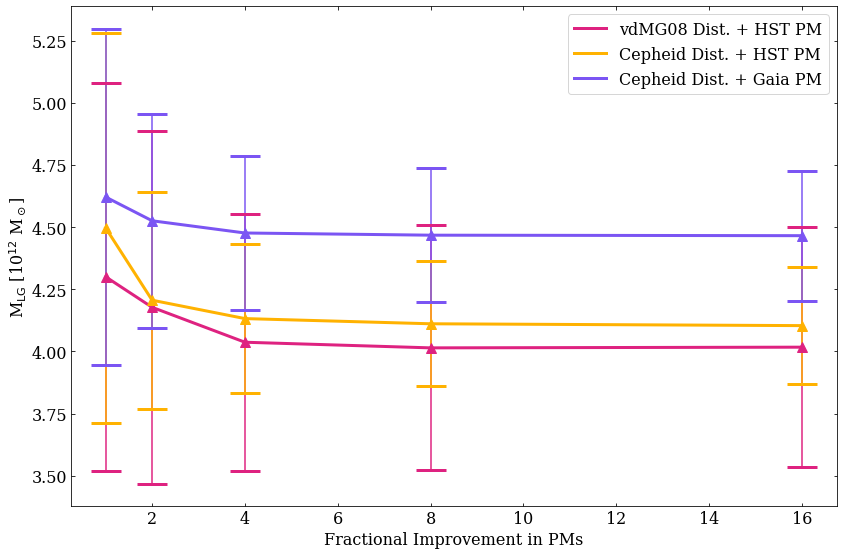

In [113]:
modelChoices = ["vdm2012","Dataset3","fiducial2021"]
label = [r"vdMG08 Dist. + HST PM",r"Cepheid Dist. + HST PM",r"Cepheid Dist. + Gaia PM"]



color = [palette["Extra"],palette['Minor Pairs'],palette['Major Pairs']]
# alpha = [0.2,0.4]

fig,ax=plt.subplots(figsize=(12,8))
for mod,lab,col in zip(modelChoices,label,color):
    
    plt.plot(means_pmimprov[mod]['pm_errs'], means_pmimprov[mod]['M'],
             label=lab, color=col, lw=3)

for mod,lab,col in zip(modelChoices,label,color):
    plt.errorbar(x=means_pmimprov[mod]['pm_errs'], 
                 y=means_pmimprov[mod]['M'],
                 yerr=stds_pmimprov[mod]['M'],
                 color=col, capsize=15,
                 capthick=3, marker='^',ms=10,
                 linestyle="")

# plt.scatter(0,0,label=r'v$_{\rm travel}$ from P21',marker="^",s=80,color='grey')
ax.set_xlabel(r'Fractional Improvement in PMs')
ax.set_ylabel(r'M$_{\rm LG}$ [10$^{12}$ M$_\odot$]')
plt.legend()
# plt.ylim(3.2,5.5)
plt.tight_layout()
# plt.savefig("../plots/analyze-runs-MvsPM.png",dpi=300)
plt.show()

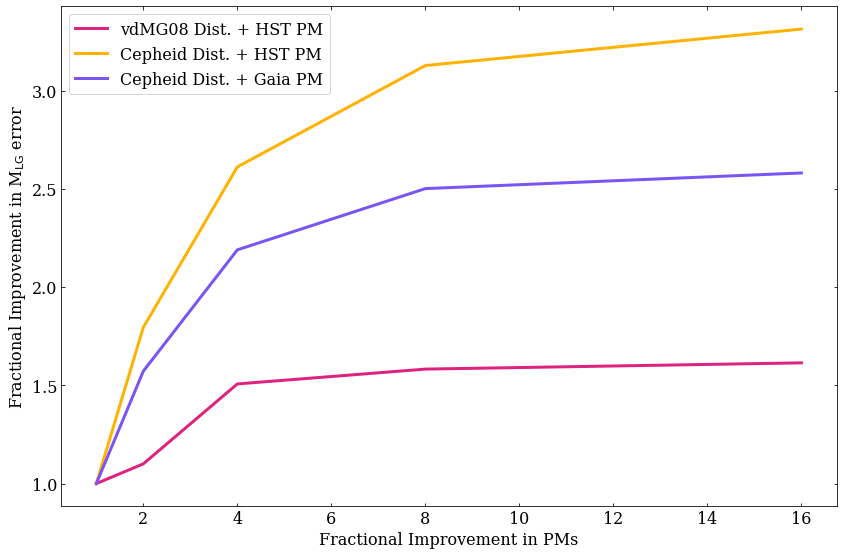

In [116]:
fig,ax=plt.subplots(figsize=(12,8))
for mod,lab,col in zip(modelChoices,label,color):
    
    plt.plot(means_pmimprov[mod]['pm_errs'], (stds_pmimprov[mod]['M']/stds_pmimprov[mod]['M'][0])**-1,
             label=lab, color=col, lw=3)

# for mod,lab,col,al in zip(modelChoices,label_model,color,alpha):
#     plt.errorbar(x=means_pmimprov[mod]['pm_errs'], 
#                  y=means_pmimprov[mod]['M'],
#                  yerr=stds_pmimprov[mod]['M'],
#                  color=col, capsize=15,
#                  capthick=3, marker='^',ms=10,
#                  linestyle="")

# plt.scatter(0,0,label=r'v$_{\rm travel}$ from P21',marker="^",s=80,color='grey')
ax.set_xlabel(r'Fractional Improvement in PMs')
ax.set_ylabel(r'Fractional Improvement in M$_{\rm LG}$ error')
plt.legend()
# plt.ylim(3.2,5.5)
plt.tight_layout()
plt.savefig("../plots/analyze-runs-deltaMvsPM.pdf")
plt.show()

In [41]:
stds_pmimprov['vdm2012']["pm_errs"]==10

array([False, False, False, False,  True, False, False, False, False])

In [43]:
stds_pmimprov['vdm2012']["M"][stds_pmimprov['vdm2012']["pm_errs"]==10]

array([1.39685868])

---

# Graveyard

## Measured vtravel

In [6]:
# vtravels_meas = np.array([0,32])
# means_vtravel_meas = {}
# stds_vtravel_meas = {}

# for mod in modelChoices:
#     means_vtravel_meas[mod]={}
#     stds_vtravel_meas[mod]={}
#     Ms, rs, es = [],[],[]
#     Ms_stds, rs_stds, es_stds = [],[],[]
#     means_vtravel_meas[mod]['vtravel'] = vtravels_meas
#     stds_vtravel_meas[mod]['vtravel'] = vtravels_meas
    
#     for vs in vtravels_meas:
#         data = az.from_json(f"../pymc3-data/{mod}_vtravel_{vs}.json")

#         for param,arr,arr_stds in zip(["M","r","e"],[Ms,rs,es],[Ms_stds, rs_stds, es_stds]):
#             arr.append(np.asarray((data.posterior[param]).mean()))
#             arr_stds.append(np.asarray((data.posterior[param]).std()))

#         for param,arr,arr_stds  in zip(["M","r","e"],[Ms,rs,es],[Ms_stds, rs_stds, es_stds]):
#             means_vtravel_meas[mod][param] = np.array(arr)
#             stds_vtravel_meas[mod][param] = np.array(arr_stds)

In [6]:
# means_vtravel_meas['fiducial2021']

In [7]:
# stds_vtravel_meas['fiducial2021']